## Notebook for Lesson 1 - Review of Neural Net Basics

Note: the lesson notebooks are created for the purpose of in-class illustrations and student experimentation after class.

Back to [week 1 slides](https://docs.google.com/presentation/d/1nHIybSe1OefjxJkdhOJg43by-Sk1k8_wYoBw6Uj50NI/edit#slide=id.g1267b8de356_1_6)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2022-fall-main/blob/master/materials/lesson_notebooks/lesson_1_NN_Review.ipynb)

In [1]:
from random import random
import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs, history1, history2):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0, 0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - no dropout')
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(0, 0.7)

    ax3 = axs[1, 0]
    ax3.set_title('accuracy - no dropout')
    ax3.plot(history1.history['categorical_accuracy'])
    ax3.plot(history1.history['val_categorical_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(0.7, 1.0)


    ax2 = axs[0, 1]
    ax2.set_title('loss - with dropout')
    ax2.plot(history2.history['loss'])
    ax2.plot(history2.history['val_loss'])
    ax2.set_ylim(0, 0.7)

    ax4 = axs[1, 1]
    ax4.set_title('accuracy - with dropout')
    ax4.plot(history2.history['categorical_accuracy'])
    ax4.plot(history2.history['val_categorical_accuracy'])
    ax4.set_ylim(0.7, 1.0)

### Entropy

[Entropy (Shannon entropy)](https://en.wikipedia.org/wiki/Shannon_entropy) is a notion of how "uncertain" the outcome of some experiment is.  The more uncertain - or the more spread out the distribution - the higher the entropy. *(Aside: some of you may have encountered "entropy" in a thermodynamics class.  Entropy as we're defining it here is conceptually similar - a notion of the amount of disorder in a system, and the concepts are closely related.)*

Mathematically, for a (discrete) random variable $X$,

$$\text{Entropy}(X) = H(X) = -\Sigma_x\ p(x) \log_2 p(x)$$

*(We take $0 \times log_2(0) = 0$, although in the "real world" probabilities are rarely equal to 0.)*

Or, in English: imagine you have some probability distribution over a discrete set of events $X$.  Loop over each event and take the product of the probability of that event and the base-2 log of the probability.  Or, put another way, find the expected value $E[-\log_2 p(x)]$ for this probability distribution.



Imagine a probability distribution $p$ across 5 outcomes.  These would correspond to the true distribution over five labels in a multi-class classification problem.

In [3]:
p = np.array([0.3,0.2,0.1,0.25,0.15])
print(p)

[0.3  0.2  0.1  0.25 0.15]


Calculate the entropy:

In [4]:
S = -(0.3 * np.log2(0.3) + 0.2 * np.log2(0.2) + 0.1 * np.log2(0.1) + 0.25 * np.log2(0.25) + 0.15 * np.log2(0.15))
print(S)

2.228212945841001


Explicit, but tedious and silly. Better way? Use vectors:

In [5]:
S = - np.dot(p, np.log2(p))
print(S)

2.228212945841001


Same result. Good. 

### Cross Entropy

What if we get the code wrong? Suppose we have a finite sample of messages (introducing some _variance_), and we train a machine learning model (introducing some _bias_) to estimate the true probabilities. Let's call the predicted distribution $Q(X)$.

Now we generate a code based on $Q(X)$, and use it to encode real messages (which come from $P(X)$). How many bits do we use, on average?

If we design an optimal code for $Q$, we use $-\log_2 Q(x)$ bits for message $x$. Then we average this over $x \sim P$ to get:

$$ \text{CE}(P,Q) = \sum_{x} - P(x) \log_2 Q(x) = \mathrm{E}_{x \sim P(x)}\left[ -\log_2 Q(x) \right] $$

Since we "crossed" the code from $Q$ and used it on $P$, this is known as the [**cross-entropy**](https://en.wikipedia.org/wiki/Cross_entropy). Note that $ \text{CE}(P,Q) \ge H(P) $, because we know that the code trained on $Q$ can't possibly be better than the optimal code on $P$ itself! 

In the form above, this is the most commonly used loss function in machine learning. In unsupervised learning (density estimation), we use it exactly as-is, with $x$ as the data. In supervised learning, we take the random variable to be the label $y$, and take our distributions to be conditional ones: $P(y\ |\ x)$ and $Q(y\ |\ x)$:
$$ \text{CE}(P,Q)(x) = \sum_{y'} -P(y'\ |\ x) \log_2 Q(y'\ |\ x) $$
It's common to average over $x$ and to approximate $P(y\ |\ x)$ with discrete samples $(x,y)$ from a test set $T$, in which case we get:

$$ \text{CE}(P,Q) 
\approx \frac{1}{|T|} \sum_{(x,y) \in T} \sum_{y'} -\mathbb{1}[y = y'] \log_2 Q(y'\ |\ x) 
= \frac{1}{|T|} \sum_{(x,y) \in T} -\log_2 Q(y\ |\ x) 
$$

We'll commonly also write this using natural logarithms, but you can always convert between the two by the formula $ \log_2(x) = \log_2(e) \cdot \ln(x) $.

### KL Divergence

We learned that we use the word "cross-entropy" to refer to the average number of bits we need if we design our code with $Q(X)$ (i.e. our model) in mind but end up sending with probability $P(X)$ (i.e. the test set).  Similarly, "entropy" is the average bits we need if we design with the right distribution in mind.

We don't yet have a name for the difference between these quantities (i.e. the size of the *penalty* for using the wrong distribution to optimize our code).  That difference is known as the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), or KL divergence for short.

It is a measure of how different two probability distributions are.  The more $Q$ differs from $P$, the worse the penalty would be, and thus the higher the KL divergence.

That is,
$$ D_{KL}(P\ ||\ Q) = CE(P, Q) - H(P)$$

From a machine learning perspective, the KL divergence measures the "avoidable" error - when our model is perfect (i.e. the *distribution* $\hat{P}(y\ |\ x_i) = P(y\ |\ x_i)$, the KL divergence goes to zero. In general, the cross-entropy loss - and prediction accuracy - will not be zero, but will be equal to the entropy $H(P)$. This "unavoidable" error is the [Bayes error rate](https://en.wikipedia.org/wiki/Bayes_error_rate) for the underlying task.

**Important note:** we're taking the true distribution $y_i = P(y\ |\ x_i) = [1, 0, 0, 0]$ in this example to be one-hot (i.e. all mass on one value). This is different from the one-hot encoding we use for training labels, which are _observations_ (single values) _sampled_ from some true distribution $y_i^\text{obs} \sim P(y\ |\ x_i)$. In that case, one-hot encoding is just a convenient shortcut. In general - and particularly in NLP - we'll have some label uncertainty, and the true distribution $P(y\ |\ x_i)$ will be spread among potentially many possibilities.

One final observation:  cross-entropy is not symmetric (think about how $P$ and $Q$ appear in the formula to understand why).  As a result KL Divergence isn't symmetric either (if you want to prove this to yourself substitute in for CE and E in the equation above and simplify).  So while KL divergence is a measure of similarity, it's useful to keep in mind that $D_{KL}(P\ ||\ Q) \ne D_{KL}(Q\ ||\ P)$.

### 1. Checking a few things about cross-entropy

Now imagine a 2nd distribution q which is close to $p$ but differs a bit. These are a prediction your model has made.  We'll construct it via a small $\delta$ vector which has a mean of zero, and whose scale is a small number $\epsilon$: 

In [6]:
def create_q(p0, epsilon=0.03):

    delta = epsilon * np.random.random(5)
    delta = delta - np.mean(delta)
    
    return (p0 + delta)

q = create_q(p)
print('q: ', q)

q:  [0.30525181 0.20507209 0.08284735 0.24582053 0.16100822]


What is the cross entropy?

In [7]:
ce = -np.dot(p, np.log2(q))
print(ce)

2.23137765878386


Close! Smaller or bigger than entropy?

In [8]:
print((ce - S) > 0)

True


Let's try that for many q:

In [9]:
for attempt in range(5):
    q = create_q(p)
    ce = -np.dot(p, np.log2(q))
    #print(q)
    print('ce > S? ', (ce-S)>0)
    

ce > S?  True
ce > S?  True
ce > S?  True
ce > S?  True
ce > S?  True


Indeed... $ce$ is always larger than $S$ ('experimentally verified', but should be proven). $ce = S$ when $q=p$, therefore minimizing $ce$ drives $q \rightarrow p$.  KL Divergence is the difference between cross entropy and entropy.

### 2. A few basic words on vector and matrix calculations 

Imagine a neural net where the dimension  of the incoming layer is $4$, and the next layer has dimension $3$. Let $x$ be the input. What are the dimensions of the weight matrix $W$ and bias vector $b$ in $$z = f(x W + b)?$$    

$W$ needs to 'translate' a 4-d vector into a 3-d vector. Hence dim$(W) = 4 \times 3$.

Each output neuron has its own bias value, dim$(b) = 3$.

Example:

In [10]:
x = np.array([1,1,2,2])

W = np.array([[-1,-3,-2],[-2,3,-6],[4,-2,3], [-1, 5, 1]]) 


b = np.array([-1, -2, -3])

In [11]:
print('x shape: ', x.shape)
print('W shape: ', W.shape)
print('b shape: ', b.shape)

x shape:  (4,)
W shape:  (4, 3)
b shape:  (3,)


In [12]:
z = x.dot(W) + b
z

array([ 2,  4, -3])

Now let's add the non-linearity, sigmoid to be concrete. The non-linearity is an element-wise operation. (The last output layer at the end however is different.)

In [13]:
def sigmoid(y):
    return 1/(1 + np.exp(-y))

In [14]:
h = sigmoid(z)
h

array([0.88079708, 0.98201379, 0.04742587])

### 3. Familiarization with the Output Layer and Softmax operation

Imagine your output layer (which does not have a non-linearity) returns these 5 numbers:

In [15]:
o = 10 * np.random.random(5) - 5
print('o: ', o)

o:  [ 0.39707935 -4.18512907 -1.084589   -0.26057558 -4.92922831]


In a classification problem, these 5 numbers would be the output for each class. They can be large, small, positive, negative, etc. 

We want to model probabilities though. Hence, we need to convert the output to 5 values that are **1) positive** and **2) sum to 1**.

Let's first exponentiate all values:

In [16]:
exp_o = np.exp(o)
print('outputs: ', exp_o)

outputs:  [1.48747396 0.01522024 0.33804069 0.77060791 0.00723208]


Great. All numbers are positive. But they don't sum to $1$. Simple solution: divide each value by the sum of all values:

In [17]:
sum_exp_o = np.sum(exp_o)
print('sum of all output values: ', sum_exp_o)

sum of all output values:  2.618574889873365


In [18]:
p = exp_o/sum_exp_o
print('model probabilities p: ', p)

model probabilities p:  [0.56804713 0.00581241 0.12909338 0.29428523 0.00276184]


In [19]:
p = exp_o/sum_exp_o
print('model probabilities q: ', p)

model probabilities q:  [0.56804713 0.00581241 0.12909338 0.29428523 0.00276184]


In [20]:
np.sum(p)

0.9999999999999999

Cool! Sums to 1 as desired. (Not a surprise.)

What happens if I add a constant to each value in $o$? How is softmax affected?

In [21]:
o_2 = o + 1

In [22]:
exp_o_2 = np.exp(o_2)
print('outputs: ', exp_o_2)

outputs:  [4.04337344 0.04137291 0.91888987 2.09472949 0.01965884]


In [23]:
sum_exp_o_2 = np.sum(exp_o_2)

In [24]:
q = exp_o_2/sum_exp_o_2
print('new probabilities q_2: ', q)

new probabilities q_2:  [0.56804713 0.00581241 0.12909338 0.29428523 0.00276184]


Same!

### 4. Most Basic Keras Intro

Simple 3-class classification model. This is only intended to illustrate the TensorFlow/Keras concepts. See: https://www.tensorflow.org/guide/keras

There are two types of formalisms: 1) **Sequential** models, and 2) **Functional API**. The former is a little simpler, but it only supports (as the name says) sequential architectures. The Functional API approach is extremely flexible and will be introduced later. (And that is the one we will generally use.)   


But for this first test we set up a **Sequential** model, wrapped in a function:

In [25]:
def create_model(dropout=0.0, num_neurons=10):
    # Define 'sequential' model (vs. 'functional'... we'll discuss later.)
    model = tf.keras.Sequential([

    # Let's go nuts in terms of layers and neurons per layer and actively try to overfit
        
    # Add 5 densely-connected layers with num_neurons units followed by dropout to the model:
    
    layers.Dense(num_neurons, activation='relu',
                 #kernel_initializer=tf.keras.initializers.glorot_normal ,
                 input_shape=(20,)),         # '20' is the number of features of the input

    # add a droput layer
    layers.Dropout(dropout),

    layers.Dense(num_neurons, activation='relu'),
    layers.Dropout(dropout),

    layers.Dense(num_neurons, activation='relu'),
    layers.Dropout(dropout),

    layers.Dense(num_neurons, activation='relu'),
    layers.Dropout(dropout),
        
    layers.Dense(num_neurons, activation='relu'),
    layers.Dropout(dropout),

    # Create a softmax layer with 3 output units - 
    # as required by the labels being 3 dimensional representinbg 3 classes:
    layers.Dense(3, activation='softmax')])
    
    # Compile model. Configure a model for categorical classification.
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.categorical_accuracy])
    
    return model

Create some fake input data ():

In [26]:
def random_one_hot_labels(num_examples, num_classes, dim):
    
    #create random data
    base_data = np.random.random((num_examples, dim))
    
    #create random labels
    classes = np.random.randint(0, num_classes, num_examples)
    labels = np.zeros((num_examples, num_classes))
    labels[np.arange(num_examples), classes] = 1
    
    # hide a small signal in the data
    label_to_data_signal = np.reshape(np.array(np.random.random(num_classes * dim)), 
                                      (num_classes, dim))
    
    signals = np.matmul(labels, label_to_data_signal)                    
    
    data = base_data + 1/2 * signals
    
    return data, labels



data, labels = random_one_hot_labels(10000, 3, 20)

Create a model without dropout:

In [27]:
model_0 = create_model(0.0, 200)

2022-04-26 22:07:58.691642: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Make a couple of predictions. Are they random?

In [28]:
model_0.predict(data[:2])

array([[0.33015588, 0.3148024 , 0.35504174],
       [0.3347085 , 0.3146776 , 0.35061386]], dtype=float32)

Pretty much...
Now then train your mode:

In [29]:
history_0 = model_0.fit(data, labels,   
          validation_split=0.2,
          epochs=100, 
          batch_size=50, 
          verbose=0)

model_0.fit(data, labels,   
          validation_split=0.2,
          epochs=1, 
          batch_size=50, 
          verbose=2)

160/160 - 1s - loss: 0.0175 - categorical_accuracy: 0.9937 - val_loss: 0.7984 - val_categorical_accuracy: 0.8735 - 703ms/epoch - 4ms/step


Now create and train a model with dropout:

In [30]:
model_2 = create_model(0.2)

history_2 = model_2.fit(data, labels,   
          validation_split=0.2,
          epochs=100, 
          batch_size=50, 
          verbose=0)

model_2.fit(data, labels,   
          validation_split=0.2,
          epochs=1, 
          batch_size=50, 
          verbose=1)

160/160 [==============================] - 0s 2ms/step - loss: 0.4672 - categorical_accuracy: 0.8298 - val_loss: 0.3600 - val_categorical_accuracy: 0.8685


Let's look at the behavior:

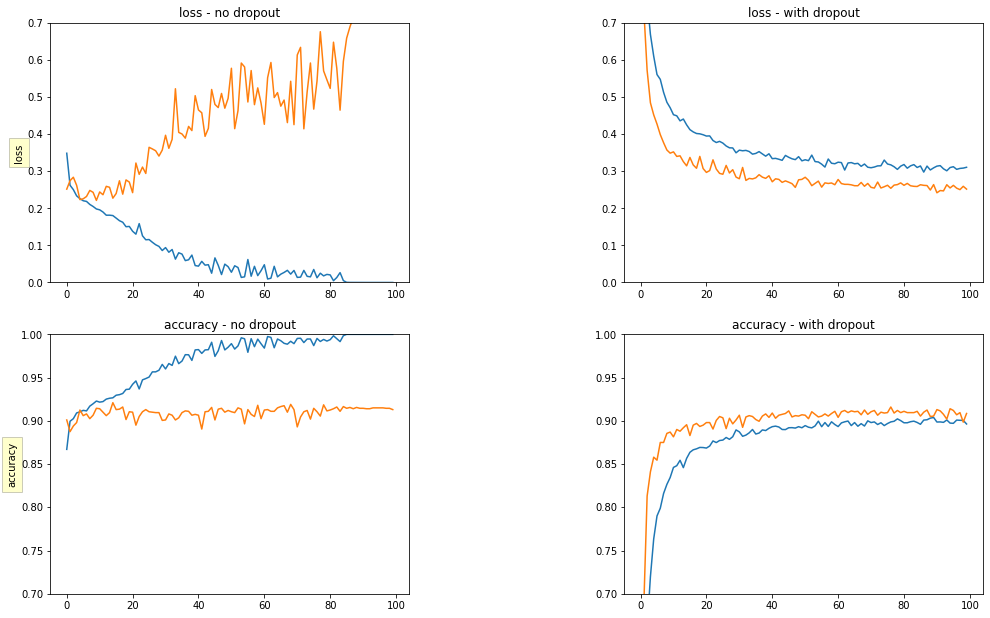

In [31]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, history_0, history_2)

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

What is the interpretation? (The example is surely very artificial.)

### 5. Effect of Layer Normalization

In the last step, let's quickly introduce the **Functional API** and then specifically looks at the effect of Layer Normalization:

In [31]:
try: 
    del function_model_layer_norm
except:
    pass

# Functional API! 
# Define inputs, then network architecture build as a series of: 
#     layer_output = layer(earlier_layer_output)
# then define model through input list and output list 

inputs = layers.Input(shape=(20,))

dense_layer =  layers.Dense(5, activation='relu',
                              kernel_initializer=tf.keras.initializers.glorot_normal,
                              name='layer_1')         

dense_out = dense_layer(inputs)

# now add layer normalization layer
final_out = layers.LayerNormalization()(dense_out)

# use actual 2 layers as model outputs to see the effect of the layer normalization:
function_model_layer_norm = tf.keras.models.Model(inputs=[inputs], outputs=[dense_out, final_out])

In [32]:
pred_layer_after_dense, pred_layer_after_norm = function_model_layer_norm.predict(data[:2], batch_size=2)
pred_layer_after_dense

array([[0.59513026, 0.        , 0.02191283, 0.        , 0.44730398],
       [0.        , 0.        , 0.        , 0.        , 0.88947654]],
      dtype=float32)

In [33]:
pred_layer_after_norm

array([[ 1.4808435, -0.8246366, -0.7397483, -0.8246366,  0.9081781],
       [-0.4980367, -0.4980367, -0.4980367, -0.4980367,  1.9921468]],
      dtype=float32)

Let's look at the sum and standard deviations of the output:

In [34]:
np.sum(pred_layer_after_norm, axis=-1)

array([1.7881393e-07, 0.0000000e+00], dtype=float32)

In [36]:
np.std(pred_layer_after_norm, axis=-1)

array([0.99964374, 0.99973196], dtype=float32)

Looks reasonable?